In [ ]:
"""
Utilizing RBF Neural Network for fault pattern classification,
for Fault Detection and Identification Course, KNTU, Spring 2023.

Programmed by Ardavan Modarres
ardavan.modarres@email.kntu.ac.ir
* 2023-05-20: Initial coding
"""

In [ ]:
# Imports
import torch
import torch.nn.functional as F                    # Parameterless functions, like activation functions
from torch import optim                            # For optimizers like SGD, Adam, etc.
from torch import nn                               # All neural network modules
from torch.utils.data import DataLoader, Dataset   # dataset managment by creating mini batches etc.
from tqdm import tqdm                              # For progress bar!
import matplotlib.pyplot as plt                    # for plotting!
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sn

In [ ]:
!pip install torchmetrics
import torchmetrics

## The previously segmented signals obtained from case western dataset are loaded and used.

(1449, 840)
(1449, 420)
(1449, 420)


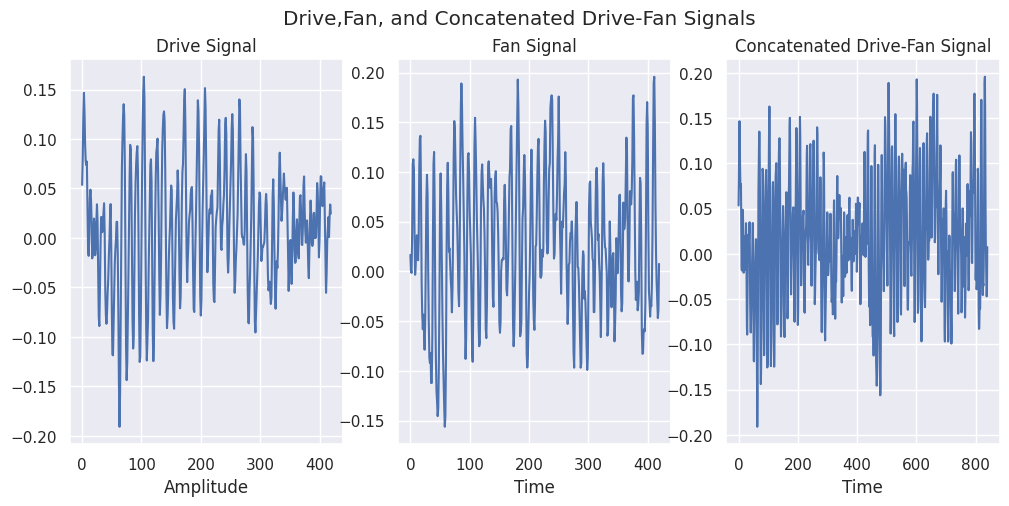

In [ ]:
data = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/data.csv'))
drive = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/drive.csv'))
fan = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/fan.csv'))
target = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/target.csv')).reshape(-1)

print(data.shape)
print(drive.shape)
print(fan.shape)

sn.set_theme(style="darkgrid")
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(drive[85, :])
plt.xlabel("Time")
plt.xlabel("Amplitude")
plt.title("Drive Signal")

plt.subplot(1, 3, 2)
plt.plot(fan[85, :])
plt.xlabel("Time")
plt.title("Fan Signal")

plt.subplot(1, 3, 3)
plt.plot(data[85, :])
plt.xlabel("Time")
plt.title("Concatenated Drive-Fan Signal")
plt.suptitle("Drive,Fan, and Concatenated Drive-Fan Signals")
plt.show()

## Dimensionality Reduction using PCA

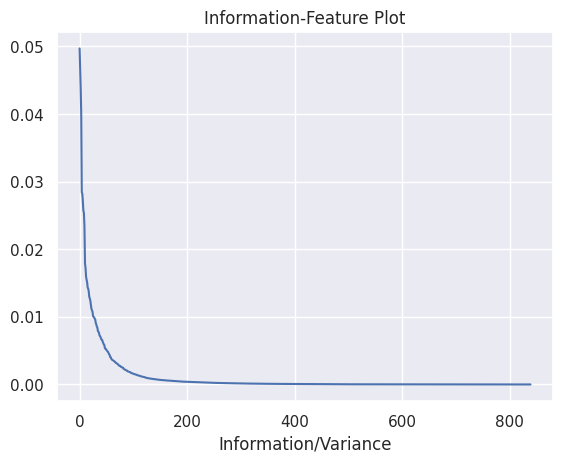

In [ ]:
pca = PCA()
pca.fit(data)

s1 = pca.explained_variance_ratio_
plt.plot(s1)
plt.xlabel("Features")
plt.xlabel("Information/Variance")
plt.title("Information-Feature Plot")
plt.show()

In [ ]:
pca = PCA(10)
data = pca.fit_transform(data)
data.shape

(1449, 10)

## Defining Custom Dataset and Neural Network and Training RBF Network

In [ ]:
class CustomSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).to(torch.float32)
        self.y = torch.from_numpy(y).to(torch.long)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

In [ ]:
class RBF_Layer(nn.Module):   # Implementation of RBF Layer
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})

    Arguments:
        in_features: size of each input sample
        num_kernels: number of kernels

    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, num_kernels) where N is an arbitrary batch size

    Attributes:
        centres: the learnable centres of shape (num_kernels, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.

        log_sigmas: logarithm of the learnable scaling factors of shape (num_kernels).

        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, in_features, num_kernels, basis_func):
        super(RBF_Layer, self).__init__()
        self.eps = torch.tensor(1e-8)
        self.centers = nn.Parameter(torch.Tensor(num_kernels, in_features))
        self.log_sigmas = nn.Parameter(torch.Tensor(num_kernels))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centers, 0, 1)
        nn.init.constant_(self.log_sigmas, 0)

    def compute_distance_vectorized(self, x_test):
        """
        Can be tricky to understand this, we utilize heavy
        vecotorization as well as numpy broadcasting.
        Idea: if we have two vectors a, b (two examples)
        and for vectors we can compute (a-b)^2 = a^2 - 2a (dot) b + b^2
        expanding on this and doing so for every vector lends to the
        heavy vectorized formula for all examples at the same time.
        """
        x_test_squared = torch.sum(x_test ** 2, axis=1, keepdims=True)
        centers_squared = torch.sum(self.centers ** 2, axis=1, keepdims=True)
        two_x_test_centers = torch.matmul(x_test, self.centers.T)

        return torch.sqrt(
            self.eps + x_test_squared - 2 * two_x_test_centers + centers_squared.T
        )

    def forward(self, x):
        distances = self.compute_distance_vectorized(x) / torch.exp(self.log_sigmas).unsqueeze(0)
        return self.basis_func(distances)

# RBF Kernels
def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2*torch.ones_like(alpha)) / 2*torch.ones_like(alpha)) \
    * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5*alpha)*torch.exp(-3**0.5*alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5*alpha + (5/3) \
    * alpha.pow(2))*torch.exp(-5**0.5*alpha)
    return phi

class RBF_Network(nn.Module):
    def __init__(self, in_features, num_kernels, num_classes, basis_func):
        super(RBF_Network, self).__init__()
        self.rbf_net = nn.Sequential(RBF_Layer(in_features, num_kernels, basis_func),
                                     nn.Linear(num_kernels, num_classes)
                                     )

    def forward(self, x):
        return self.rbf_net(x)

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 4e-3
batch_size = 64
num_epochs = 50
in_features = 10
num_kernels = 50
num_classes = 4
basis_func = gaussian

model = RBF_Network(in_features, num_kernels, num_classes, basis_func).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training Procedure useful functions

In [ ]:
def get_info(model, loader):
  batch_loss = []
  epoch_loss = []
  temp_loss = []
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for (data, targets) in loader:
      # Get data to device
      data = data.to(device=device)
      targets = targets.to(device=device)

      # Forward
      logits = model(data)
      _, predictions = logits.max(1)
      loss = criterion(logits, targets)

      # Taking record of losses
      batch_loss.append(loss.item())

      # Check how many we got correct
      num_correct += (predictions == targets).sum()
      # Keep track of number of samples
      num_samples += predictions.size(0)
  model.train()
  return (num_correct/num_samples).item(), sum(batch_loss)/len(batch_loss)

In [ ]:
# Train Network
def Train(model, device, criterion, optimizer, num_epochs):
  train_loss = []
  validation_loss = []
  train_acc = []
  validation_acc = []
  for epoch in range(num_epochs):
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to device
          data = data.to(device=device)
          targets = targets.to(device=device)

          # Forward
          logits = model(data)
          loss = criterion(logits, targets)

          # Backward
          optimizer.zero_grad()
          loss.backward()

          # Gradient descent or adam step
          optimizer.step()

      # Taking record of losses
      tr_acc, tr_loss = get_info(model, train_loader)
      val_acc, val_loss = get_info(model, validation_loader)
      train_loss.append(tr_loss)
      validation_loss.append(val_loss)
      train_acc.append(tr_acc)
      validation_acc.append(val_acc)

  plt.figure(figsize=(10, 6))
  #plot 1:
  plt.subplot(1, 2, 1)
  plt.plot(train_acc)
  plt.plot(validation_acc)
  plt.title("Accuracy")
  plt.legend(['Train Accuracy', 'Validation Accuracy'])
  #plot 2:
  plt.subplot(1, 2, 2)
  plt.plot(train_loss)
  plt.plot(validation_loss)
  plt.title("Loss")
  plt.legend(['Train Loss', 'Validation Loss'])
  plt.suptitle("Performance")
  plt.show()

## Defining a simple function for checking accuracy

In [ ]:
# Check accuracy on training & test to see how good our model
def get_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Forward pass
            logits = model(x)
            _, predictions = logits.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

## Drive Dataset Instanciation

In [ ]:
dataset = CustomSet(data, target)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

### Training Procedure

100%|██████████| 19/19 [00:00<00:00, 350.57it/s]


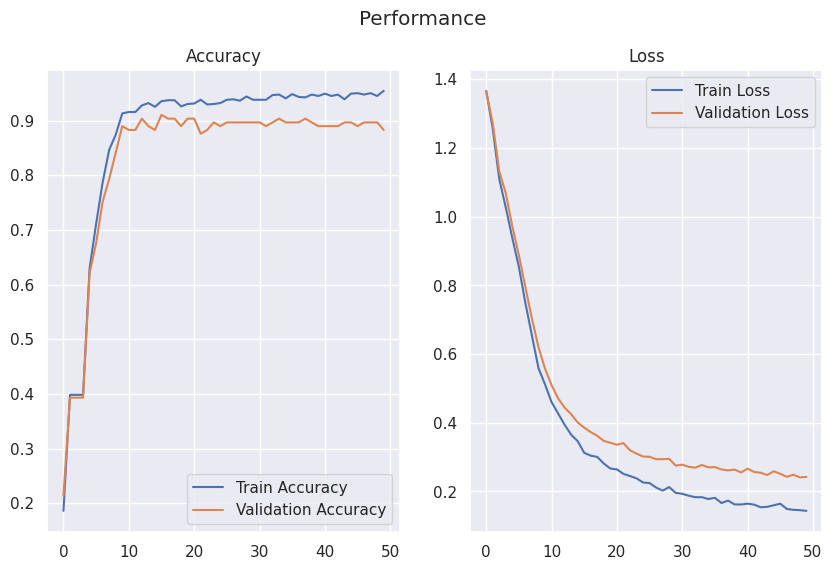

In [ ]:
Train(model, device, criterion, optimizer, num_epochs)

In [ ]:
# Check accuracy on training & test
print(f"Accuracy on training set: {get_acc(train_loader, model)*100:.2f}")
print(f"Accuracy on training set: {get_acc(validation_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_acc(test_loader, model)*100:.2f}")

Accuracy on training set: 95.43
Accuracy on training set: 88.28
Accuracy on test set: 94.44


Accuracy Of Model On Test Data Is :  tensor(93.0398)
Percision Of Model On Test Data Is :  tensor(92.4451)
Recall Of Model On Test Data Is :  tensor(93.0398)
F1-Score Of Model On Test Data Is :  tensor(92.5000)

Confusion Matrix Of Model On Test Data Is : 


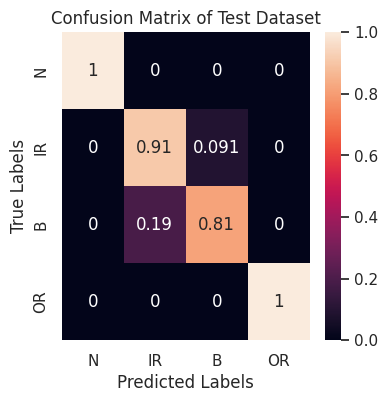

In [ ]:
predictions = torch.zeros(len(test_set))
targets = torch.zeros(len(test_set))
pointer = 0

model.eval()
with torch.no_grad():
  for x, y in test_loader:
    logits = model(x)
    _, preds = logits.max(1)
    predictions[pointer: pointer+x.shape[0]] = preds
    targets[pointer: pointer+x.shape[0]] = y
    pointer+=x.shape[0]


  accuracy = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=4)
  precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=4)
  recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=4)
  f1score = torchmetrics.F1Score(task="multiclass", average='macro', num_classes=4)
  confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)

  a = accuracy(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  p = precision(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  r = recall(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  f1s = f1score(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  cm = confmat(predictions, targets.reshape(-1,).to(dtype=torch.int64))


  print("Accuracy Of Model On Test Data Is : ", 100*a)
  print("Percision Of Model On Test Data Is : ", 100*p)
  print("Recall Of Model On Test Data Is : ", 100*r)
  print("F1-Score Of Model On Test Data Is : ", 100*f1s)
  print("")

  print("Confusion Matrix Of Model On Test Data Is : ")
  cm = cm/cm.sum(dim=1).reshape(4,1)
  plt.figure(figsize = (4, 4))
  sn.heatmap(cm, annot=True, xticklabels=['N', 'IR', 'B', 'OR'],
            yticklabels=['N', 'IR', 'B', 'OR'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title("Confusion Matrix of Test Dataset")
  plt.show()